In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3 
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear') #, align_corners=True
        self.conv3_t = nn.Conv2d(64, 64, 3, 1, 1) # Decoder - 3
        self.conv2_t = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 2
        self.conv1_t = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 1
        self.conv0_t = nn.Conv2d(16, 1, 3, 1, 1) # Final Decoder
        
    def forward(self, x):
        out = self.bn16(F.relu(self.conv1(x)))
        out = self.bn32(F.relu(self.conv2(out)))
        out = self.bn64(F.relu(self.conv3(out)))
        out = self.upsample(self.bn64(F.relu(self.conv3_t(out))))
        out = self.upsample(self.bn32(F.relu(self.conv2_t(out))))
        out = self.upsample(self.bn16(F.relu(self.conv1_t(out))))
        out = torch.tanh(self.conv0_t(out))
        return out

In [3]:
MAX_EPOCHS = 5000

file = 'saturn'
im = imread('../data/denoising/{}.png'.format(file))
noise = imread('../data/denoising/{}-noisy.png'.format(file))
noisy_img = torch.FloatTensor(noise).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)

net = EncDec()
criterion, optimizer = nn.MSELoss(), optim.Adam(net.parameters(), lr=0.01)
eta = torch.randn(*noisy_img.size())
training_error, testing_error, runtime_stats = np.zeros((MAX_EPOCHS)), np.zeros((MAX_EPOCHS)), {}

for itr in range(MAX_EPOCHS+1):
    out = net(eta)
    optimizer.zero_grad()
    loss = criterion(out, clean_img)
    loss.backward()
    optimizer.step()
    
    if itr % 100 == 0:
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        curr_error = ((im - out_img)**2).sum()
        print ("Loss = {}, Error = {}".format(loss.detach().numpy().reshape(-1)[0], curr_error))

/home/ec2-user/anaconda3/envs/cs682/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Loss = 0.3199147880077362, Error = 31448.903205110102
Loss = 0.0016218408709391952, Error = 159.43343901610197
Loss = 0.0010425278451293707, Error = 102.48465388895474
Loss = 0.0006859278655610979, Error = 67.42945451049285
Loss = 0.00043487310176715255, Error = 42.74976394080252
Loss = 0.0003089487727265805, Error = 30.370900669378123
Loss = 0.00040730510954745114, Error = 40.039721481165564
Loss = 0.000209372301469557, Error = 20.582134654175636
Loss = 0.0001818592572817579, Error = 17.87749202190475
Loss = 0.0001635542284930125, Error = 16.078034281244317
Loss = 0.00015907066699583083, Error = 15.637282884589197
Loss = 0.00014403699606191367, Error = 14.159412779163189
Loss = 0.0001531794259790331, Error = 15.05815024159489
Loss = 0.00014496625226456672, Error = 14.25076247099677
Loss = 0.000306486472254619, Error = 30.128846439189424
Loss = 0.00012128368689445779, Error = 11.922671356698144
Loss = 0.0001223907747771591, Error = 12.031502543128381
Loss = 0.00014595000538975, Error =

KeyboardInterrupt: 

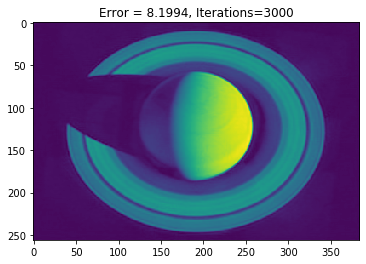

In [6]:
out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
curr_error = ((im - out_img)**2).sum()
plt.title('Error = %.4f, Iterations=%d' % (8.199352940256652, 3000) )
plt.imshow(out_img)
plt.show()